# Single-cell evidence enrichment analysis

In [3]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import json

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils
import upsetplot

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [12]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [13]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [14]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [15]:
%%R

### Plotting utils
evidence_labels <- c(
    "any" = "Any evidence", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "DE in disease", 
    "ct_marker_evidence" = "Cell type marker", 
    "has_genetic_support" = "Genetic association"
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    text_position='right',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'any')
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=rev(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha)
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=clinical_status, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -0.1) , 
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Drug target class') +
        theme_classic(base_size=20) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

## Reproducing association with genetics evidence

In [16]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)

In [17]:
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

### Compute OR with different universe of targets

- All protein-coding genes
- All targets in OpenTargets
- All targets with known drugs
- All small-molecule tractable targets
- All antibody-tractable targets

In [18]:
## Get all disease IDs in scRNA-seq data
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_OT_targets.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_OT_targets.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]

In [19]:
len(all_disease_ids)

41

Get dictionary for all the universes (to use when the same universe is used for all diseases)

In [20]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

Run association testing

In [290]:
results_genetics_df = pd.DataFrame()
genetics_all_df = OT_targets_df.copy()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'all_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
        or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'cxg_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [291]:
# Variable universe x disease cases
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    ## All OT targets
    or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'OT_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'OT_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    ## Known drug OT targets
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.known_drug > 0], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[(genetics_all_df.known_drug > 0) & (genetics_all_df.disease_ontology_id.isin(all_disease_ids))], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

### plot results

In [302]:
%%R -i results_genetics_df -h 1000 -w 700
results_genetics_df %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'known_drug_targets', 'OT_targets', 'sm_tractable_targets', 'ab_tractable_targets'))) %>%
    drop_na() %>%
    plot_OR(text_position='left') +
    facet_wrap(universe~disease_ontology_id, ncol=2) +
    ggsave(paste0(figdir, 'OR_genetics.png'), height=12, width=11)
    ggsave(paste0(figdir, 'OR_genetics.pdf'), height=12, width=11)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [306]:
OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())]

,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,is_approved,has_genetic_support
2,ENSG00000000003,MONDO_0004970,0.0,0.0,0,0,0,0,0
8,ENSG00000000003,MONDO_0005061,0.0,0.0,0,0,0,0,0
16,ENSG00000000003,MONDO_0005233,0.0,0.0,0,0,0,0,0
33,ENSG00000000003,MONDO_0004975,0.0,0.0,0,0,0,0,0
46,ENSG00000000005,MONDO_0005011,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2045908,ENSG00000291237,MONDO_0004975,0.0,0.0,0,0,0,0,0
2045917,ENSG00000291237,MONDO_0005147,0.0,0.0,0,0,0,0,0
2045927,ENSG00000291237,MONDO_0007254,0.0,0.0,0,0,0,0,0
2045936,ENSG00000291237,MONDO_0007915,0.0,0.0,0,0,0,0,0


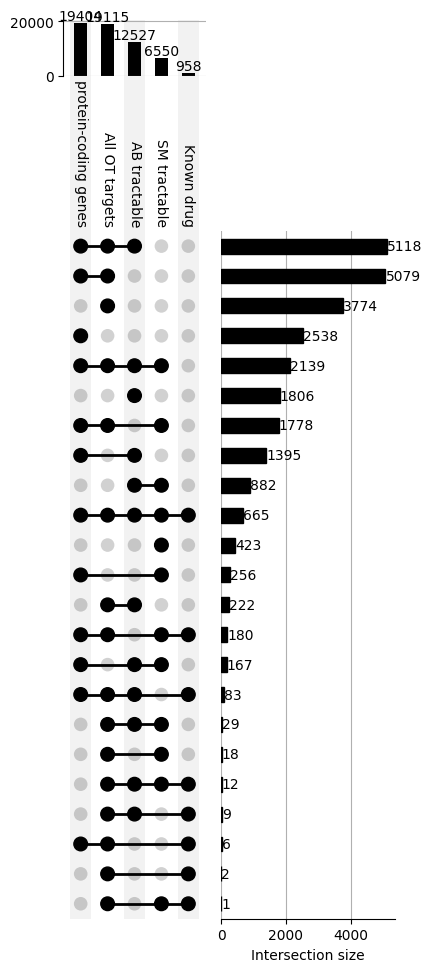

In [311]:
upset_dict = {'protein-coding genes':universe_dict['protein_coding_targets'],
    'SM tractable':universe_dict['sm_tractable_targets'],
    'AB tractable':universe_dict['ab_tractable_targets'],
     'Known drug':OT_targets_df[(OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & (OT_targets_df.known_drug > 0)].gene_id.unique().tolist(),
     'All OT targets': OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].gene_id.unique().tolist()
    }
target_universe_upset = upsetplot.from_contents(upset_dict)

with plt.rc_context({'figure.figsize':[20,10]}):
    pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='vertical', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=28
    )
    pl.plot()
    plt.savefig(figdir + 'upset_gene_universe.png')
    plt.savefig(figdir + 'upset_gene_universe.pdf')

## Get single-cell evidence from DE results and merge with OT evidence 

In [21]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.1,
    DE2evidence_celltype_params = {"lfc_thresh":1.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":1.0, 'lfc_group':'all'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict.update(disease_evidence)
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)

    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [22]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]

In [23]:
## Save evidence results for each disease
targets_evidence_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.1,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'all'}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_all = pd.concat([targets_evidence_all, targets_disease_df], axis=0)
#     targets_disease_df.to_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv')

targets_evidence_all['any'] = (targets_evidence_all[['ct_marker_evidence', 'disease_ct_evidence', 'has_genetic_support']].sum(1) > 0).astype('int')
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

missing MONDO_0012883
missing MONDO_0018874


## Association statistics

Collect evidence and clinical status for all tested diseases.

In [856]:
# targets_evidence_all = pd.DataFrame()

# ## For each disease
# for disease_ontology_id in all_disease_ids:
#     try:
#         OT_targets_disease_df = pd.read_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv', index_col=0)
#         OT_targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
#         OT_targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
#         targets_evidence_all = pd.concat([targets_evidence_all, OT_targets_disease_df], axis=0)
#     except FileNotFoundError:
#         continue

In [217]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv')

In [218]:
# Check number of diseases 
print(f"Tot. no of diseases considered: {targets_evidence_all['disease_ontology_id'].nunique()}")

Tot. no of diseases considered: 35


Compute odds-ratios for all diseases together with different universes

In [219]:
# OR_disease_df = compute_grouped_OR(targets_evidence_all, group_by = 'disease_ontology_id')
# OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ":")] for x in OR_disease_df.disease_ontology_id]
# OR_tissue_df = compute_grouped_OR(targets_evidence_all, group_by = 'disease_relevant_tissue')

In [220]:
targets_evidence_all[['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']].sum()

disease_ct_evidence      182506.0
ct_marker_evidence        51512.0
disease_evidence         266322.0
bulk_disease_evidence     96485.0
has_genetic_support        4989.0
any                      221104.0
dtype: float64

In [221]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

Add variable universe x disease cases

In [222]:
# Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].copy()
# Merge with sc evidence (keeping just OT targets)
OT_targets_test_df = pd.merge(OT_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
        ## All OT targets
        or_df = association_utils.get_OR(OT_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'OT_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [223]:
# Get all known drug OT targets for selected diseases 
known_drug_targets_test_df = OT_targets_df[
    (OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & \
    (OT_targets_df['known_drug'] > 0)
].copy()

# Merge with sc evidence (keeping just OT targets)
known_drug_targets_test_df = pd.merge(known_drug_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
        ## All OT targets
        or_df = association_utils.get_OR(known_drug_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'known_drug_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

## Plot results

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


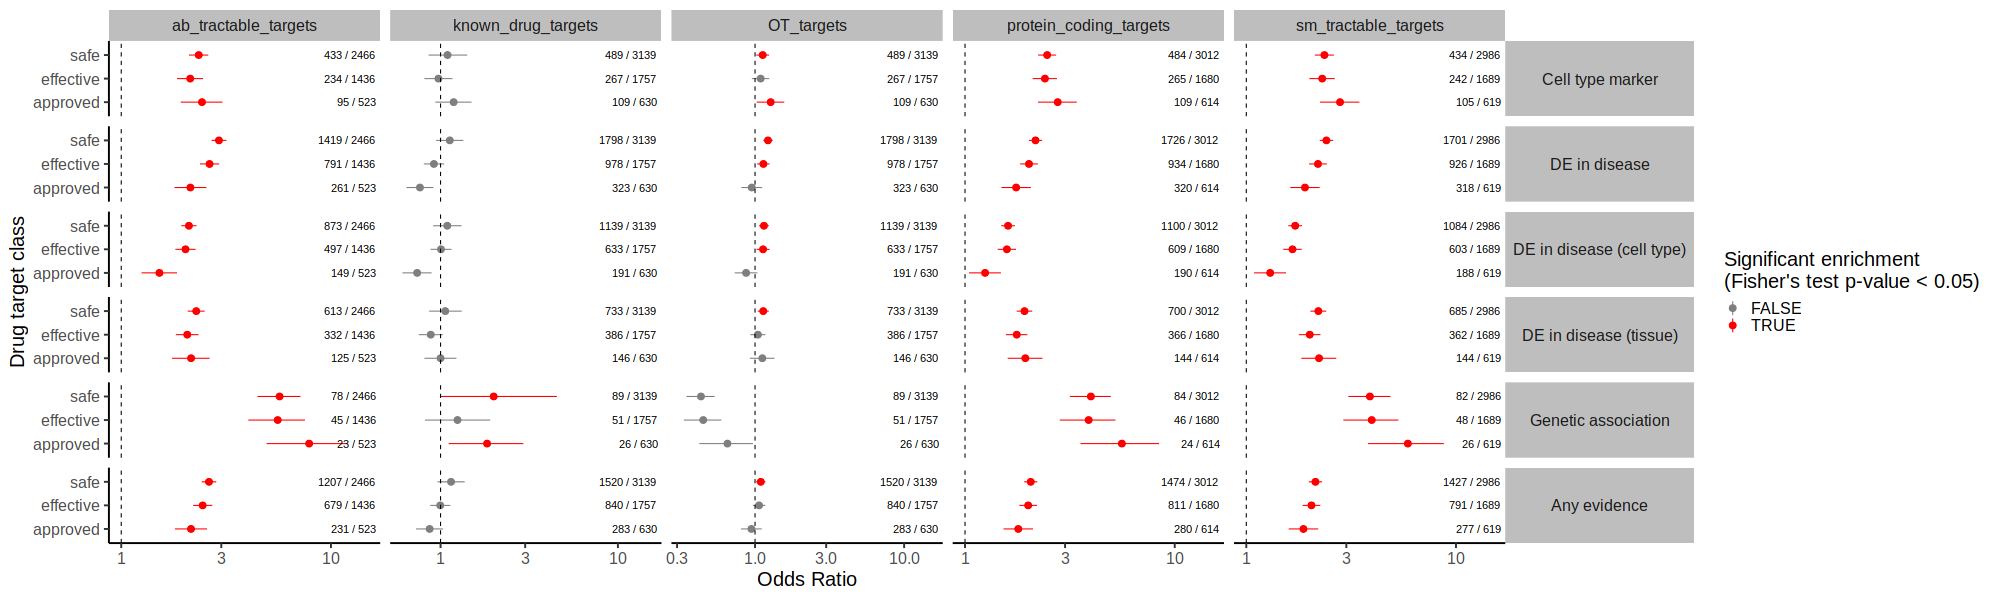

In [224]:
%%R -i results_all_df -w 2000 -h 600 -i figdir
plot_OR(results_all_df, text_position='right') +
facet_grid(evidence~universe, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          ) +
expand_limits(x=15) +
ggsave(paste0(figdir, 'OR_results_all.png'), height=6, width=22)

## Test combination of genetic and single-cell support

In [225]:
for sc_evidence in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence']:
    targets_evidence_all[f'genetic_and_{sc_evidence}'] = ((targets_evidence_all['has_genetic_support'] == 1) & (targets_evidence_all[sc_evidence] == 1)).astype(int)
#     targets_evidence_all[f'genetic_or_{sc_evidence}'] = ((targets_evidence_all['has_genetic_support'] == 1) | (targets_evidence_all[sc_evidence] == 1)).astype(int)

In [226]:
results_all_df = pd.DataFrame()
evidence_cols =  [
    'has_genetic_support', 
    'genetic_and_disease_ct_evidence', 'genetic_and_ct_marker_evidence', 'genetic_and_disease_evidence']

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

# Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].copy()
# Merge with sc evidence (keeping just OT targets)
OT_targets_test_df = pd.merge(OT_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in evidence_cols:
        ## All OT targets
        or_df = association_utils.get_OR(OT_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'OT_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

# Get all known drug OT targets for selected diseases 
known_drug_targets_test_df = OT_targets_df[
    (OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & \
    (OT_targets_df['known_drug'] > 0)
].copy()

# Merge with sc evidence (keeping just OT targets)
known_drug_targets_test_df = pd.merge(known_drug_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in evidence_cols:
        ## All OT targets
        or_df = association_utils.get_OR(known_drug_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'known_drug_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


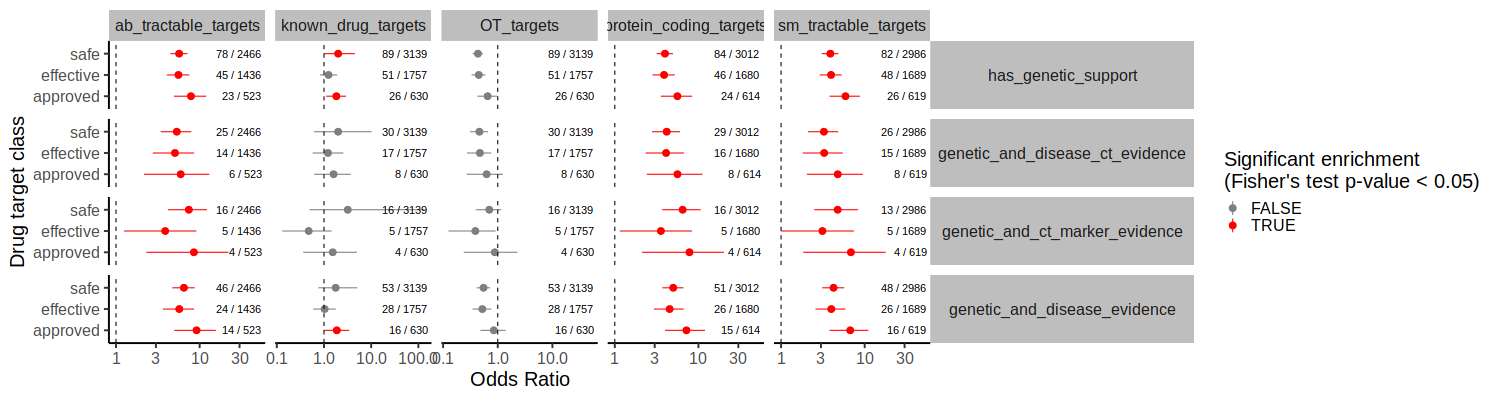

In [229]:
%%R -i results_all_df -i evidence_cols -w 1500 -h 400
plot_OR(results_all_df, 
        text_position='right', 
        evidence_levels = evidence_cols) +
facet_grid(evidence~universe, scale='free_x'
#            labeller = labeller(evidence=as_labeller(evidence_labels))
          ) +
expand_limits(x=50) +
ggsave(paste0(figdir, 'OR_results_intersect.png'), height=6, width=22)

### Overlap between evidence sets

In [312]:
targets_evidence_all['target_disease'] = targets_evidence_all['gene_id'] + "_" + targets_evidence_all['disease_ontology_id']

In [313]:
targets_evidence_all['disease_evidence'].sum()

266322.0

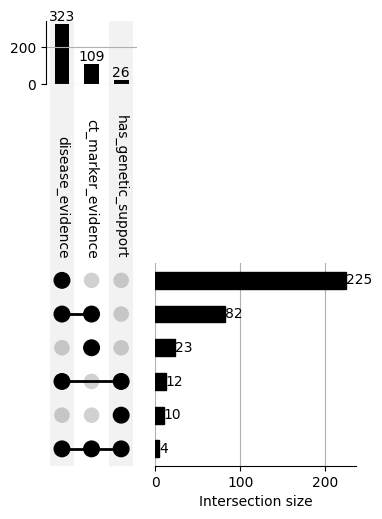

In [314]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_evidence_all.target_disease[
        (targets_evidence_all[ev] == 1)
        & (targets_evidence_all.is_approved == 1)
    ].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

pl = upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality', 
)
pl.plot()
plt.savefig(figdir + 'upset_evidence_approved.pdf')
plt.savefig(figdir + 'upset_evidence_approved.png')

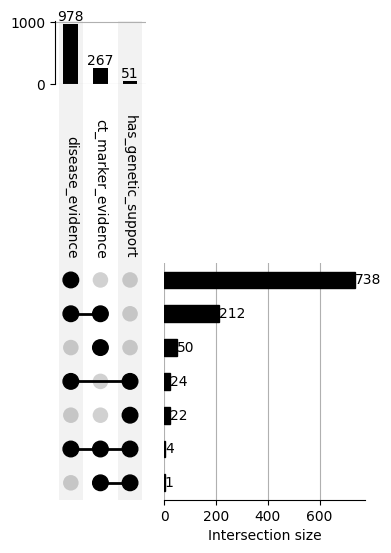

In [315]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_evidence_all.target_disease[(targets_evidence_all[ev] == 1) & (targets_evidence_all.is_effective == 1)].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

pl = upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality'
)

pl.plot()
plt.savefig(figdir + 'upset_evidence_effective.pdf')
plt.savefig(figdir + 'upset_evidence_effective.png')

## Stratified OR

In [98]:
evidence_cols =  ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support']

n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
test_diseases = n_x_disease.index[(n_x_disease['disease_ct_evidence'] > 0) & (n_x_disease['is_approved'] > 0)]

OR_disease_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all['disease_ontology_id'].isin(test_diseases)], 
    group_by = 'disease_ontology_id', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

/tmp/ipykernel_9039/2595948422.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()


In [99]:
OR_disease_df['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]
OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]

In [100]:
disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


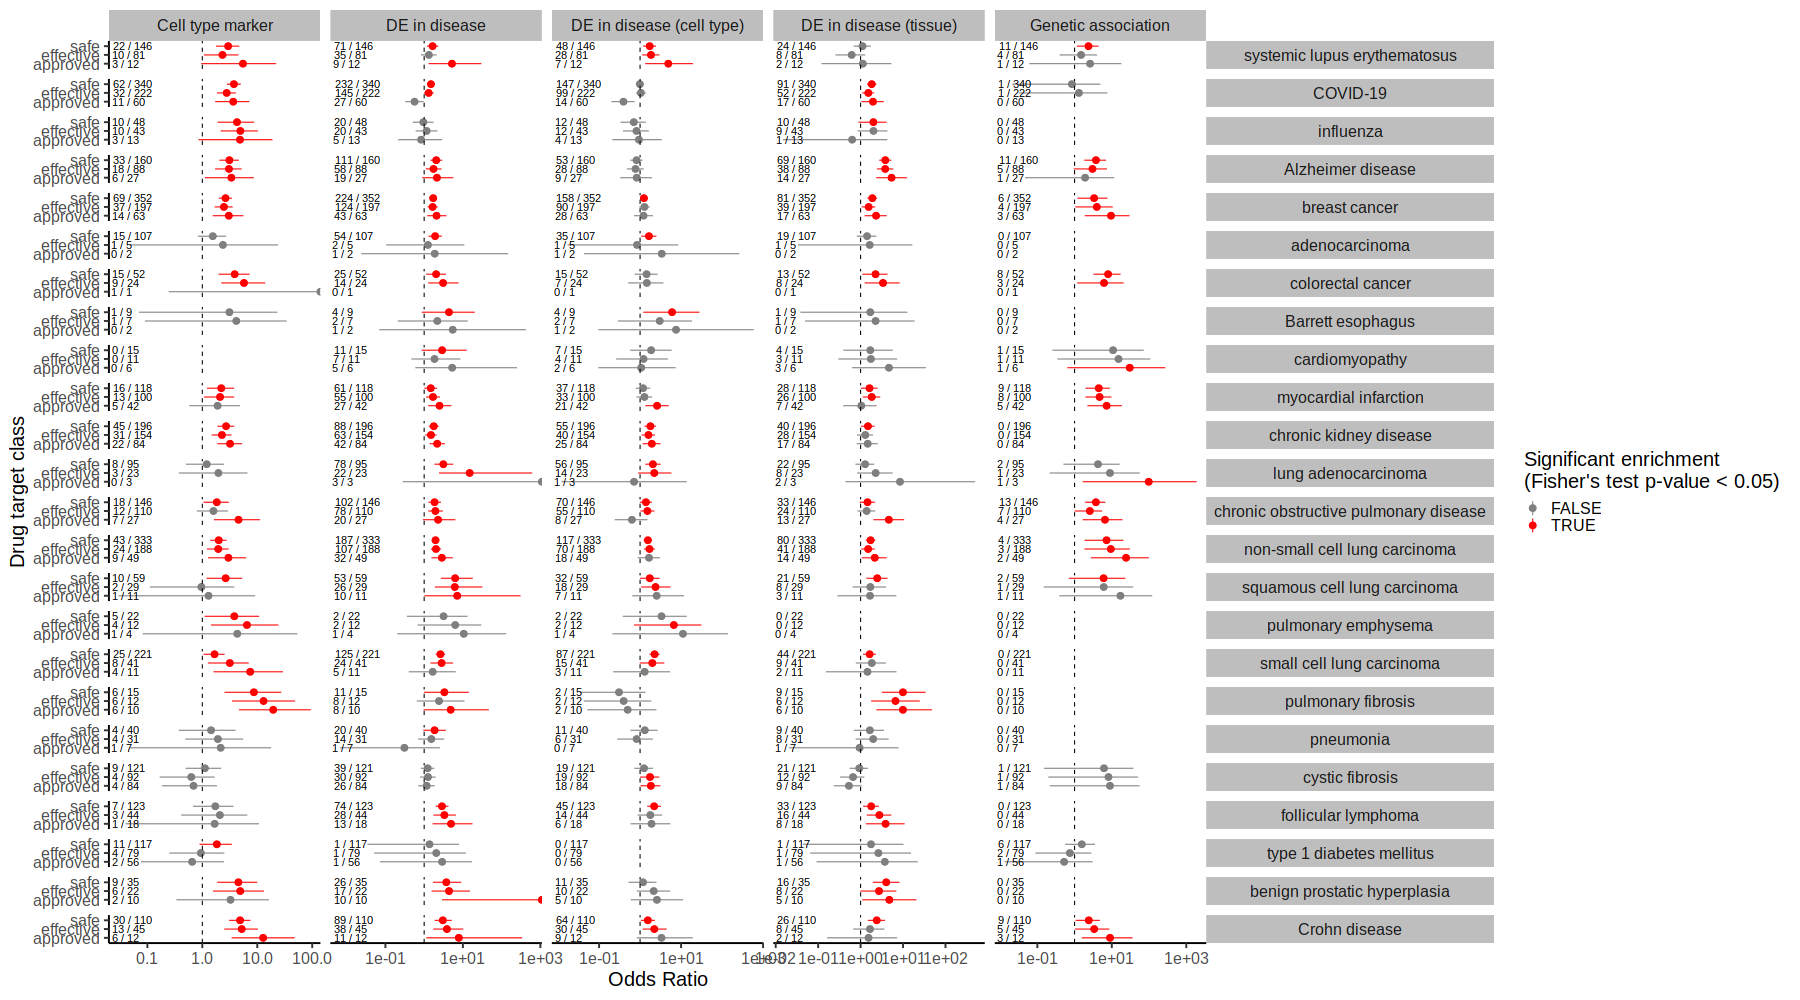

In [113]:
%%R -i OR_disease_df -h 1000 -w 1800 -i disease_order

OR_disease_df <- mutate(OR_disease_df, disease = factor(disease, levels=as.list(disease_order))) 

plot_OR(OR_disease_df, 
        text_position='left') +
    facet_grid(disease~evidence, scales='free_x',
               labeller = labeller(evidence = as_labeller(evidence_labels))) +
    expand_limits(x=0.05) +
    ggsave(paste0(figdir, 'OR_results.by_disease.png'), height=18, width=25)

In [114]:
n_x_tissue = targets_evidence_all.groupby('disease_relevant_tissue').sum()
test_tissues = n_x_tissue.index[(n_x_tissue['disease_ct_evidence'] > 0) & (n_x_tissue['is_approved'] > 0)]

OR_tissue_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all.disease_relevant_tissue.isin(test_tissues)], 
    group_by = 'disease_relevant_tissue', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

/tmp/ipykernel_9039/694968752.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_tissue = targets_evidence_all.groupby('disease_relevant_tissue').sum()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


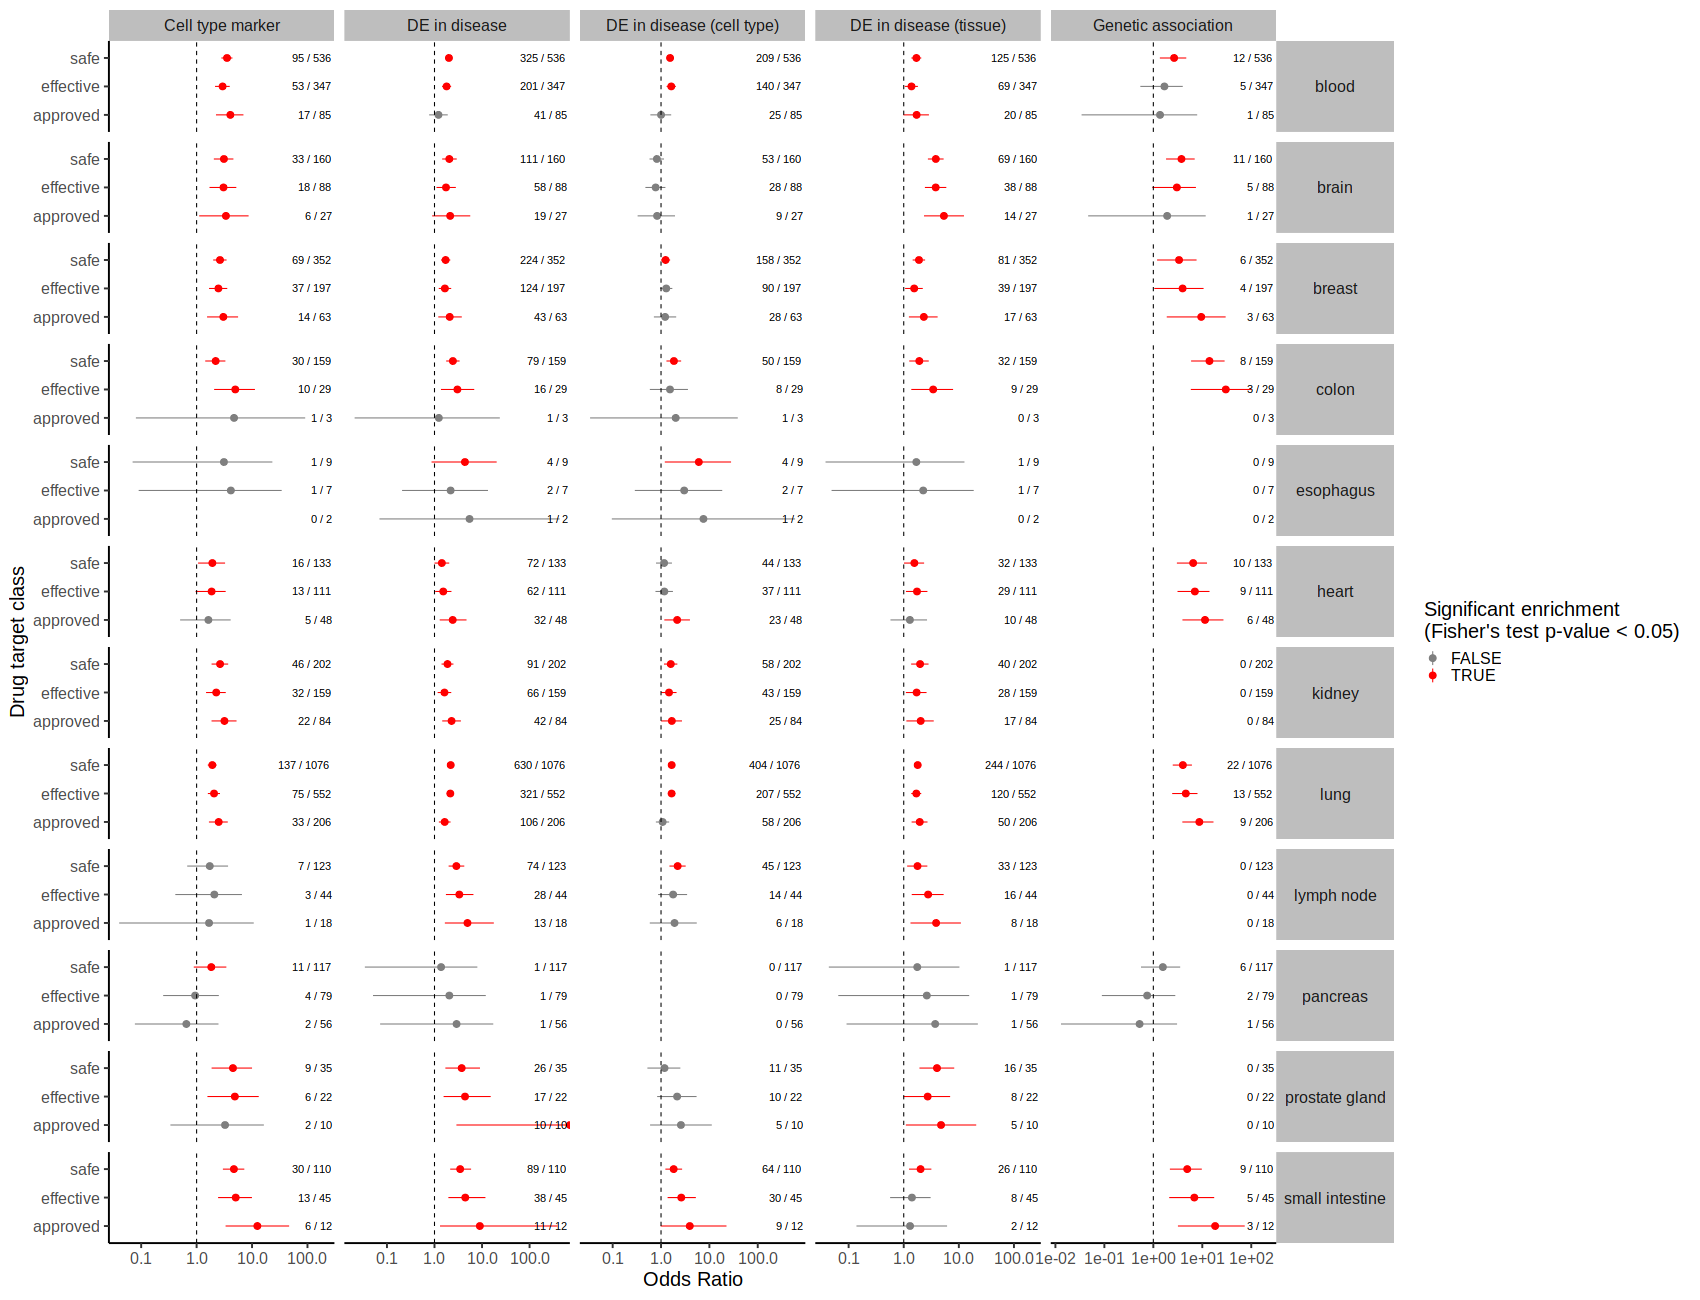

In [115]:
%%R -i OR_tissue_df -h 1300 -w 1700 

plot_OR(OR_tissue_df,  text_position='right') +
    facet_grid(disease_relevant_tissue~evidence, 
               labeller = labeller(evidence = as_labeller(evidence_labels)),
               scales='free_x'
              ) +
    expand_limits(x=200) +
    ggsave(paste0(figdir, 'OR_results.by_tissue.png'), height=18, width=25)

## Test dependency on lfc and fraction of cell type in marker genes

In [31]:
targets_evidence_all_lfc = pd.DataFrame()
for min_lfc in [0.1, 1, 2, 3, 4, 5,6,7]:
    for disease_ontology_id in all_disease_ids:
        try:
            targets_disease_df = _parse_DE(
                disease_ontology_id, OT_targets_df,
                signif_thresh = 0.1,
                DE2evidence_celltype_params = {"lfc_thresh":min_lfc, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":min_lfc, 'lfc_group':'all'},
            )
        except FileNotFoundError:
            continue
        targets_disease_df['min_lfc'] = min_lfc
        targets_evidence_all_lfc = pd.concat([targets_evidence_all_lfc, targets_disease_df], axis=0)

In [37]:
targets_evidence_all_lfc.to_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

In [19]:
targets_evidence_all_lfc = pd.read_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

Association statistics

In [28]:
lfc_OR_all = pd.DataFrame()

for u in universe_dict.keys():
    lfc_OR = association_utils.compute_grouped_OR(
        targets_evidence_all_lfc, 
        group_by = 'min_lfc', 
        evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence'],
        clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
        gene_universe = universe_dict[u]
        )
    lfc_OR['universe'] = u
    lfc_OR_all = pd.concat([lfc_OR_all, lfc_OR])
   

In [29]:
 # Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all_lfc.disease_ontology_id.unique())].copy()

# Merge with sc evidence (keeping just OT targets)
OT_targets_lfc_df = pd.DataFrame()
for fc in targets_evidence_all_lfc.min_lfc.unique():
    df = pd.merge(OT_targets_test_df, targets_evidence_all_lfc[targets_evidence_all_lfc.min_lfc == fc], how='left').fillna(0)
    df['min_lfc'] = fc
    OT_targets_lfc_df = pd.concat([OT_targets_lfc_df, df])
    
lfc_OR = association_utils.compute_grouped_OR(
        OT_targets_lfc_df, 
        group_by = 'min_lfc', 
        evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence'],
        clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
        )
lfc_OR['universe'] = 'OT_targets'
lfc_OR_all = pd.concat([lfc_OR_all, lfc_OR])

In [34]:
%%R
plot_OR_lfc <- function(
    results_all_df, 
    pval_alpha=0.05, 
    text_position='right',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'any')){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        mutate(min_lfc = factor(min_lfc, levels=rev(unique(min_lfc))))
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=min_lfc, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Min. logFC') +
#         coord_flip() +
        theme_classic(base_size=20) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


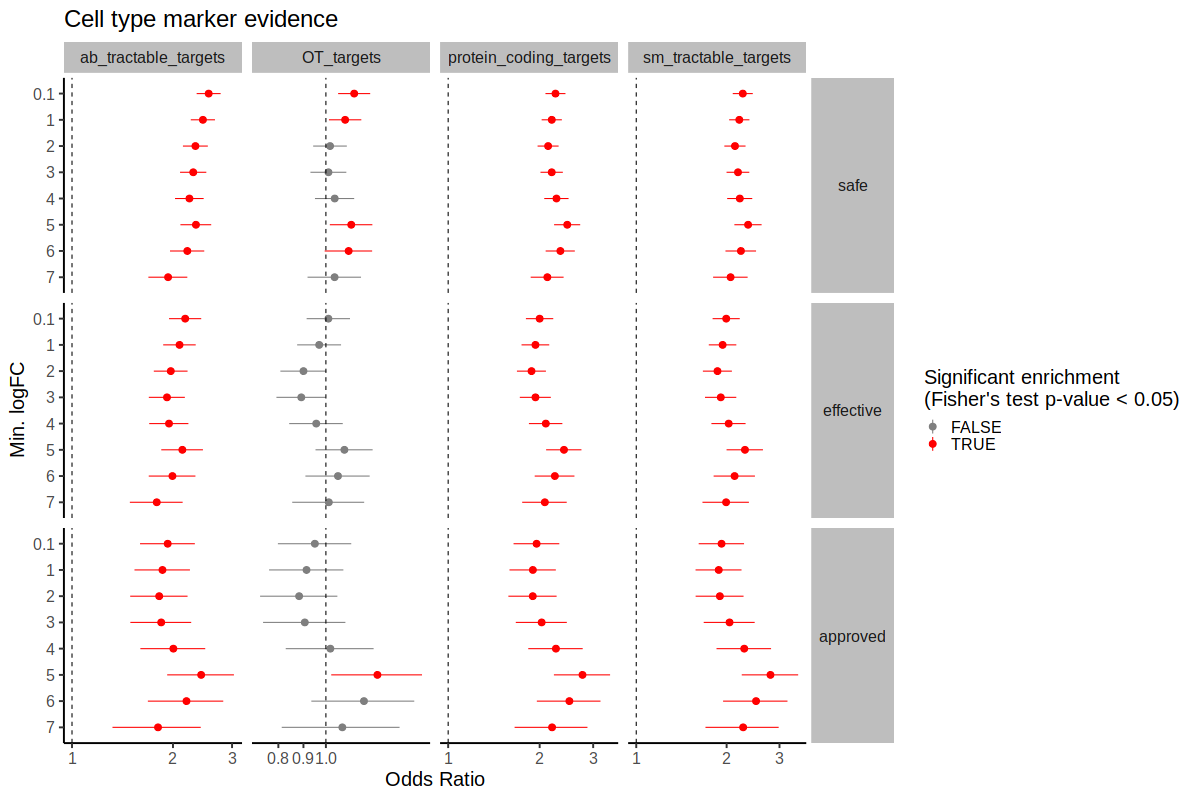

In [279]:
%%R -i lfc_OR_all -w 1200 -h 800
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'ct_marker_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('Cell type marker evidence') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_marker_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_marker_evidence.pdf'), height=8, width=15)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


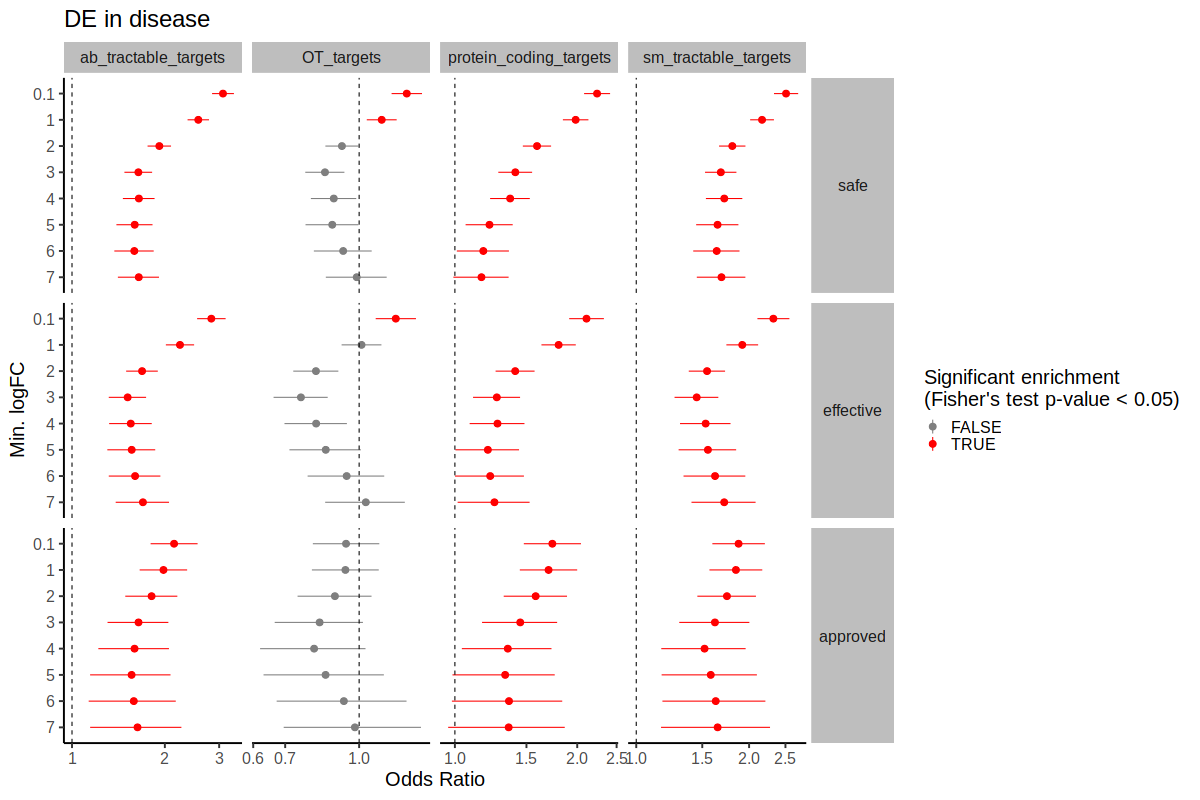

In [280]:
%%R -i lfc_OR_all -w 1200 -h 800
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'disease_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('DE in disease') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_evidence.pdf'), height=8, width=15)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


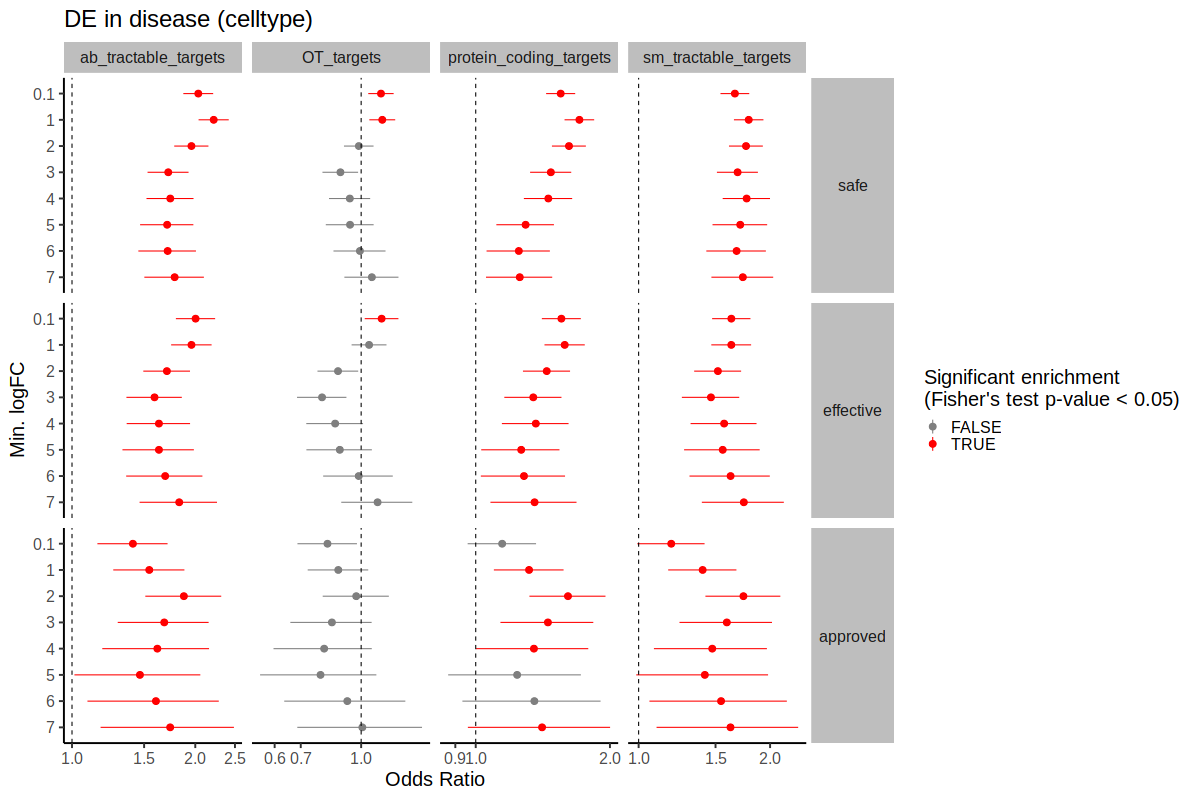

In [281]:
%%R -i lfc_OR_all -w 1200 -h 800  
plot_OR_lfc(lfc_OR_all %>% filter(evidence == 'disease_ct_evidence')) +
    facet_grid(clinical_status~universe, scales='free_x') +
    theme(strip.placement='outside') +
    ggtitle('DE in disease (celltype)') +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_ct_evidence.png'), height=8, width=15) +
    ggsave(paste0(figdir, 'OR_results.by_lfc_disease_ct_evidence.pdf'), height=8, width=15)

In [119]:
pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()

/tmp/ipykernel_9039/112256373.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


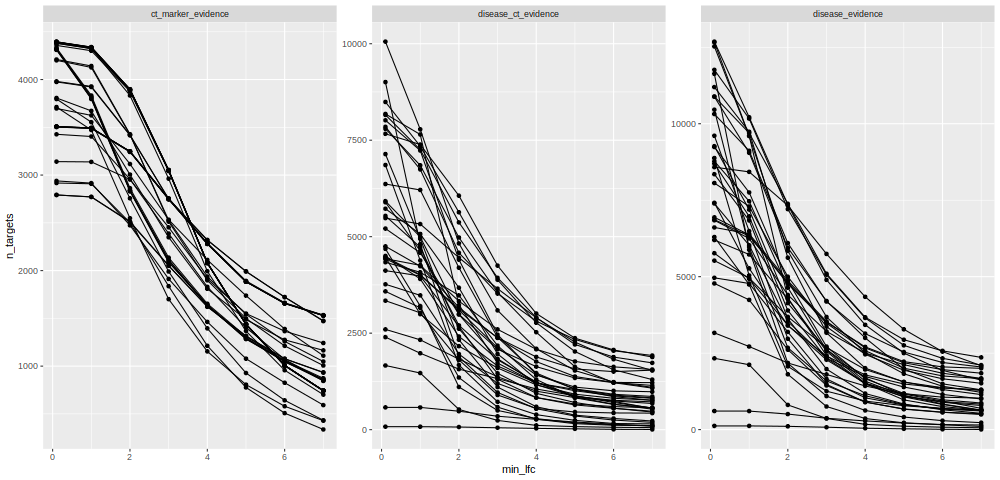

In [129]:
%%R -i pl_df -w 1000
pl_df %>%
pivot_longer(cols = c(ct_marker_evidence, disease_evidence, disease_ct_evidence), values_to='n_targets', names_to='sc_evidence') %>%
ggplot(aes(min_lfc, n_targets)) +
geom_point() +
geom_line(aes(group=disease_ontology_id)) +
facet_wrap(sc_evidence~., scales='free')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


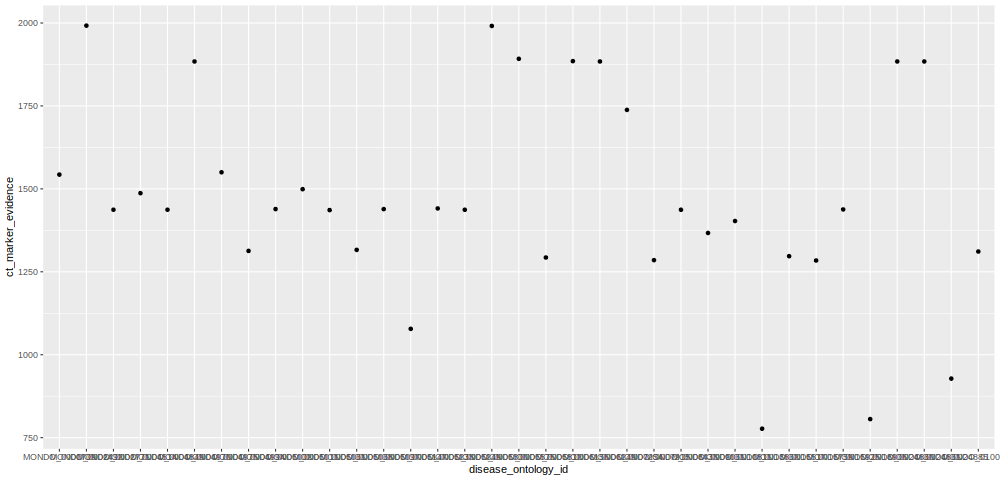

In [134]:
%%R -i pl_df -w 1000
pl_df %>%
filter(min_lfc == 5) %>%
# pivot_longer(cols = c(ct_marker_evidence, disease_evidence, disease_ct_evidence), values_to='n_targets', names_to='sc_evidence') %>%
ggplot(aes(disease_ontology_id, ct_marker_evidence)) +
geom_point() 

### More diagnostic plots for DE results

For both:
- Number of tested celltypes vs number of targets with evidence (for both)

For celltype markers:
- Check overlap in ct_marker targets between cell types present across tissues: jaccard index for marker evidence genes for each cell type across tissues --> do we cluster by cell type or tissue? or, check mean JI of matched cell type vs other cell types

For disease markers:
- How does the overlap btw disease-specific and bulk genes change with logFC? 


In [253]:
# Get number of tested targets x disease
def _ncelltypes_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    return(ct_res['high_level_cell_type_ontology_term_id'].nunique(), disease_res['high_level_cell_type_ontology_term_id'].nunique())

In [254]:
targets_evidence_all['n_cts_markers'] = np.nan
targets_evidence_all['n_cts_disease'] = np.nan

for disease_ontology_id in all_disease_ids:
    try:
        n_cts_markers, n_cts_disease = _ncelltypes_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_markers'] = n_cts_markers
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_disease'] = n_cts_disease
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue

missing MONDO_0001627
missing MONDO_0018874
missing MONDO_0012883
missing MONDO_0005115
missing MONDO_0016691
missing MONDO_0018177


In [255]:
n_targets_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()
n_targets_by_disease = pd.merge(n_targets_by_disease, targets_evidence_all[['n_cts_markers', 'n_cts_disease', 'disease_ontology_id']].drop_duplicates())

/tmp/ipykernel_9039/1027269127.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_targets_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()


In [256]:
n_targets_by_disease['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace("_", ":")] for x in n_targets_by_disease.disease_ontology_id]

In [287]:
%%R -i n_targets_by_disease -w 1000 -h 500
pl1 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_markers, ct_marker_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ggpubr::stat_cor(size=7) +
    ylab('# celltype marker targets') +
    xlab('# tested celltypes') 


pl2 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_disease, disease_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ylab('# DE in disease targets') +
    xlab('# tested celltypes') +
    ggpubr::stat_cor(size=7, aes(n_cts_disease, disease_evidence), inherit.aes = FALSE)

pl3 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_disease, disease_ct_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    theme_classic(base_size=18) +
    ylab('# DE in disease (cell type) targets') +
    xlab('# tested celltypes') +
    ggpubr::stat_cor(size=7, aes(n_cts_disease, disease_ct_evidence), inherit.aes = FALSE)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


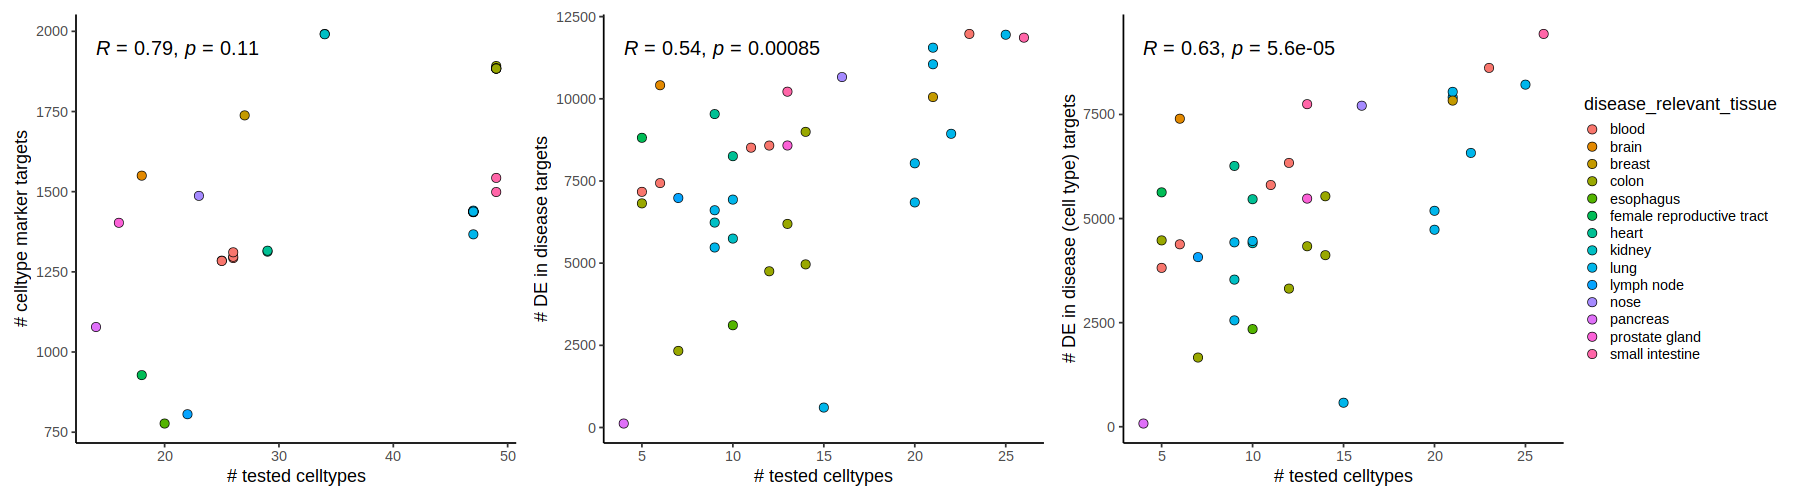

In [288]:
%%R -i n_targets_by_disease -w 1800 -h 500
(pl1 | pl2 | pl3) + plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.png'), height=5, width=18) +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.pdf'), height=5, width=18) 

In [248]:
OR_disease_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,disease_ontology_id,disease_relevant_tissue,disease
0,1.724335,0.999929,2.994282,0.025016,59.0,11577.0,32.0,7912.0,disease_ct_evidence,is_safe,MONDO_0005097,lung,squamous cell lung carcinoma
0,2.379812,1.063773,5.579124,0.016714,29.0,11607.0,18.0,7912.0,disease_ct_evidence,is_effective,MONDO_0005097,lung,squamous cell lung carcinoma
0,2.543076,0.646253,11.850678,0.109101,11.0,11625.0,7.0,7912.0,disease_ct_evidence,is_approved,MONDO_0005097,lung,squamous cell lung carcinoma
0,2.658630,1.198007,5.327781,0.008577,59.0,11577.0,10.0,1389.0,ct_marker_evidence,is_safe,MONDO_0005097,lung,squamous cell lung carcinoma
0,0.960668,0.110594,3.829581,0.624753,29.0,11607.0,2.0,1389.0,ct_marker_evidence,is_effective,MONDO_0005097,lung,squamous cell lung carcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.617119,0.256518,1.283157,0.935205,81.0,7704.0,8.0,2922.0,bulk_disease_evidence,is_effective,MONDO_0007915,blood,systemic lupus erythematosus
0,1.128212,0.120135,5.298052,0.558893,12.0,7773.0,2.0,2922.0,bulk_disease_evidence,is_approved,MONDO_0007915,blood,systemic lupus erythematosus
0,2.366364,1.147925,4.399291,0.010389,146.0,7639.0,11.0,652.0,has_genetic_support,is_safe,MONDO_0007915,blood,systemic lupus erythematosus
0,1.497076,0.396638,4.009514,0.289469,81.0,7704.0,4.0,652.0,has_genetic_support,is_effective,MONDO_0007915,blood,systemic lupus erythematosus


In [262]:
pl_df = pd.merge(OR_disease_df, n_targets_by_disease[['n_cts_markers', 'n_cts_disease', 'disease_ontology_id']])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


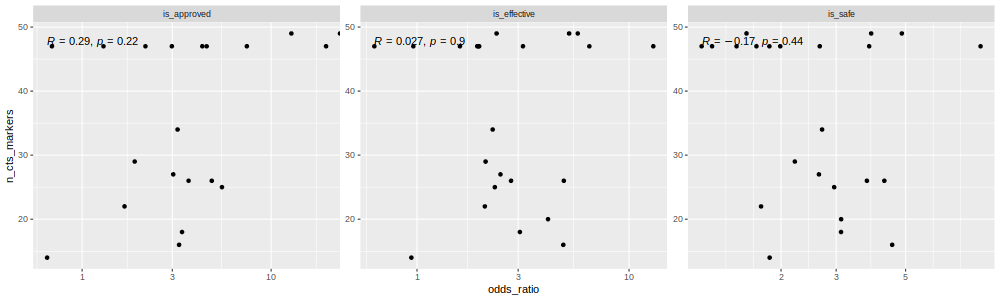

In [274]:
%%R -i pl_df -w 1000 -h 300
pl_df %>%
filter(evidence == 'ct_marker_evidence') %>%
ggplot(aes(odds_ratio, n_cts_markers)) +
geom_point(data = . %>% filter(n_supported_approved > 0)) +
# geom_pointrange(data = . %>% filter(n_supported_approved > 0),
#                         aes(xmin=ci_low, xmax=ci_high)) +
scale_x_log10() +
ggpubr::stat_cor() +
facet_wrap(clinical_status~., scales='free')